<a href="https://colab.research.google.com/github/MarkVoitov/DS_ABB/blob/main/Section%205%3A%20Neural%20networks/pytorch_cnn/MNIST_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST с CNN
Применяем сверточную нейронную сеть (CNN) к MNIST.
Перед выполнением вспомните, то такое
* сверточные слои
* фильтры / ядра
* пулинг
* шаг (stride) и padding

Обратите внимание, что в этом упражнении нет необходимости выравнивать данные MNIST, поскольку CNN ожидает двумерные данные.

## Импорт

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем данные MNIST 
PyTorch обеспечивает доступ к обучающим и тестовым наборам данных (включая данные MNIST) через <a href='https://pytorch.org/docs/stable/torchvision/index.html'> <tt> <strong> torchvision </strong> </tt> </a>. При первом вызове наборы данных будут загружены на ваш компьютер по указанному пути. С этого момента torchvision всегда будет искать локальную копию перед попыткой загрузки.

Мы будем использовать преобразования (transform) и класс <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'> <tt> <strong> DataLoader </strong> </tt> </a>.

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

### Создаем загрузчики данных
При работе с изображениями нам нужны относительно небольшие батчи; размер батча равный 4 -- не редкость.

In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


## Определить сверточную модель

Мы будем использовать два сверточных слоя и два пулинга, прежде чем передавать данные через полносвязные скрытые слои на выход. Структура модели: CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

Далее мы проиллюстрируем работу сети по шагам

In [ ]:
# определим слои
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [ ]:
# берем первую запись
for i, (X_train, y_train) in enumerate(train_data):
    break

In [ ]:
# создаем тензор
# 
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [ ]:
# выполняем первую свертку: convolution/activation
x = F.relu(conv1(x))
print(x.shape)
# batch_size x channels x H x W
# размер батча х цветов х высота х ширина 

torch.Size([1, 6, 26, 26])


In [ ]:
# Выполняем первый пулинг
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [ ]:
# выполняем вторую свертку: convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [ ]:
# Выполняем второй пулинг
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [ ]:
# "расплющиваем" данные 
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


Вот как вывод сверточного слоя передается в полносвязанный слой.

Далее опишем то же, но уже в классе модели

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

С учетом bias-нейронов для каждого слоя общее количество обучаемых параметров составляет: <br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Определяем функцию потерь и оптимизатор

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Обучаем модель


In [ ]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# цикл по эпохам
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # цикл по батчам
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # применяем модель
        y_pred = model(X_train)  
#         print(y_train)
        loss = criterion(y_pred, y_train)
 
        # Считаем количество правильных прогнозов
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Обновляем параметры
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Выводим промежуточные результаты
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Запусткаем на тестовых батчах
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Применяем модель
            y_val = model(X_test)

            # Считаем количество правильных прогнозов (на тесте)
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

epoch:  0  batch:  600 [  6000/60000]  loss: 0.05620493  accuracy:  99.267%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00234961  accuracy:  99.183%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00001659  accuracy:  99.167%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00022505  accuracy:  99.225%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00000319  accuracy:  99.260%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00003750  accuracy:  99.231%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.01552648  accuracy:  99.207%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00003825  accuracy:  99.225%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00145499  accuracy:  99.254%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03866885  accuracy:  99.248%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00000223  accuracy:  99.500%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00016161  accuracy:  99.433%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.23034331  accuracy:  99.417%
epoch:  1  b

## Отрисовываем значения фугкции потерь

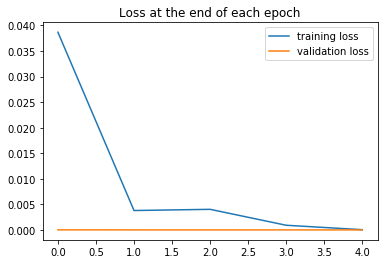

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
test_losses

[tensor(0.0024),
 tensor(0.0013),
 tensor(0.0011),
 tensor(5.9553e-05),
 tensor(0.0001)]

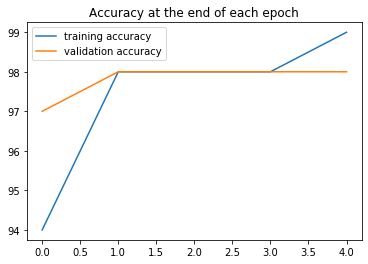

In [ ]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Оцениваем на тестовом наборе

In [ ]:
# работаем сразу со всем множетсвом (не по батчам)
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9852/10000 =  98.520%


Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214 parameters to our current 60,074.

## Показываем матрицу расхождений

In [ ]:

np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()


print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 980    0    6    0    0    3    6    3   11    3]
 [   0 1130    7    0    0    0    1    2    0    1]
 [   0    0 1007    1    0    0    0    4    0    0]
 [   0    1    1 1006    0    9    0    1    1    1]
 [   0    0    1    0  980    0    2    0    1   10]
 [   0    2    0    1    0  862    1    0    2    2]
 [   0    0    0    0    1    1  944    0    0    1]
 [   0    0    9    0    0    1    0 1010    1    4]
 [   0    2    1    2    0    6    4    2  957   11]
 [   0    0    0    0    1   10    0    6    1  976]]


## Запускаем модель на одном изображении
Мы также можем передать одно изображение на вход модели, чтобы получить метку класса.
Выберите число от 0 до 9999, которое мы будем использовать для выбора номера примера из MNIST.

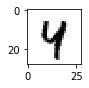

In [ ]:
x = 42
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [ ]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Ответ модели:",new_pred.item())

Ответ модели: 4
